# Assignment 3

## 1. Setup

In [113]:
# Import necessary libraries

from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import numpy as np
import pandas as pd
from __future__ import annotations
from typing import Tuple, List, Iterable, Dict, Optional
import matplotlib.pyplot as plt
import random
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed 
import math
import os
from dataclasses import dataclass
from collections import defaultdict



# Baseline Analysis
Run a baseline system analysis for the EV Stag Hunt model:
- Heatmap of final adoption X* vs (X0, I0)
- Phase plots (I(t), X(t)) for representative initial conditions
- Sensitivity curves: final adoption vs beta_I for several X0

Produces PNG plots and CSV data in ./output_ev_analysis/

### Model Implementation

In [122]:
from __future__ import annotations
import networkx as nx
import random
import math
from typing import Dict, Optional
# Imports needed for the existing code and type hints
# Added: networkx, random, math, Dict, Optional, np

# Strategy update functions

def choose_strategy_imitate(agent, neighbors):
    """Choose strategy of the highest-payoff neighbour (including self)."""
    candidates = neighbors + [agent]
    best = max(candidates, key=lambda a: a.payoff)
    return best.strategy

# Agent and Model classes

class EVAgent:
    def __init__(self, node_id: int, model: "EVStagHuntModel", init_strategy: str = "D"):
        self.node_id = node_id
        self.model = model
        self.strategy = init_strategy  # "C" or "D"
        self.payoff = 0.0
        self.next_strategy = init_strategy

    def step(self) -> None:
        """Compute payoff from interactions with neighbours."""
        I = self.model.infrastructure
        a0 = self.model.a0
        beta_I = self.model.beta_I
        b = self.model.b
        a_I = a0 + beta_I * I

        neighbors = list(self.model.G.neighbors(self.node_id))
        if not neighbors:
            self.payoff = 0.0
            return

        payoff = 0.0
        for nbr in neighbors:
            other = self.model.node_agent_map[nbr]
            s_i = self.strategy
            s_j = other.strategy
            if s_i == "C" and s_j == "C":
                payoff += a_I
            elif s_i == "C" and s_j == "D":
                payoff += 0.0
            elif s_i == "D" and s_j == "C":
                payoff += b
            else:  # D vs D
                payoff += b
        self.payoff = payoff

    def advance(self) -> None:
        """Compute next_strategy according to model's strategy_choice_func but DO NOT commit."""
        func = self.model.strategy_choice_func
        neighbors = [self.model.node_agent_map[n] for n in self.model.G.neighbors(self.node_id)]

        if func == "imitate":
            candidates = neighbors + [self]
            best = max(candidates, key=lambda a: a.payoff)
            self.next_strategy = best.strategy
        elif func == "logit":
            a_I = self.model.a0 + self.model.beta_I * self.model.infrastructure
            pi_C = 0.0
            pi_D = 0.0
            for other in neighbors:
                if other.strategy == "C":
                    pi_C += a_I
                    pi_D += self.model.b
                else:
                    pi_C += 0.0
                    pi_D += self.model.b
            tau = getattr(self.model, "tau", 1.0)
            denom = math.exp(pi_C / tau) + math.exp(pi_D / tau)
            P_C = math.exp(pi_C / tau) / denom if denom > 0 else 0.5
            self.next_strategy = "C" if random.random() < P_C else "D"
        else:
            raise ValueError(f"Unknown strategy choice function: {func}")

    def commit(self) -> None:
        """Apply next_strategy synchronously."""
        self.strategy = self.next_strategy


class EVStagHuntModel:
    def __init__(
        self,
        initial_ev: int,
        a0: float,
        beta_I: float,
        b: float,
        g_I: float,
        I0: float,
        seed: int | None,
        network_type: str,
        n_nodes: int,
        p: float,
        m: int,
        strategy_choice_func: str = "imitate",
        tau: float = 1.0,
    ):
        self.random = random.Random(seed)
        self.seed = seed
        self.a0 = a0
        self.beta_I = beta_I
        self.b = b
        self.g_I = g_I
        self.infrastructure = float(I0)
        self.strategy_choice_func = strategy_choice_func
        self.tau = tau

        # Build network
        if network_type == "ER":
            G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)
        elif network_type == "WS":
            G = nx.watts_strogatz_graph(n_nodes, max(2, 2*m), p, seed=seed)
        elif network_type == "BA":
            G = nx.barabasi_albert_graph(n_nodes, max(1, m), seed=seed)

        self.G = G

        # create agents: one per node
        nodes = list(self.G.nodes())
        total_nodes = len(nodes)
        k_ev = max(0, min(initial_ev, total_nodes))
        ev_nodes = set(self.random.sample(nodes, k_ev))
        self.node_agent_map: Dict[int, EVAgent] = {}
        for node in nodes:
            init_strategy = "C" if node in ev_nodes else "D"
            agent = EVAgent(node, self, init_strategy)
            self.node_agent_map[node] = agent

    def get_adoption_fraction(self) -> float:
        agents = list(self.node_agent_map.values())
        if not agents:
            return 0.0
        return sum(1 for a in agents if a.strategy == "C") / len(agents)

    def get_avg_clustering_coefficient(self) -> float:
        """Returns the average clustering coefficient of the network."""
        if len(self.G) == 0:
            return 0.0
        # networkx.average_clustering computes the average of the local clustering coefficients
        return nx.average_clustering(self.G)
        
    def step(self) -> None:
        # compute payoffs
        for agent in list(self.node_agent_map.values()):
            agent.step()
        # choose next strategies (based on payoffs)
        for agent in list(self.node_agent_map.values()):
            agent.advance()
        # commit synchronously
        for agent in list(self.node_agent_map.values()):
            agent.commit()
        # update infrastructure: I <- clip(I + g_I*(X - I), 0, 1)
        X = self.get_adoption_fraction()
        I = self.infrastructure
        dI = self.g_I * (X - I)
        self.infrastructure = float(min(1.0, max(0.0, I + dI)))

def set_initial_adopters(model, X0_frac, method="random", seed=None, high=True):
    """Set a fraction of agents to EV adopters using different heuristics."""
    rng = np.random.default_rng(seed)
    agents = model.schedule.agents
    n = len(agents)
    k = int(round(X0_frac * n))

    for a in agents:
        a.strategy = "D"

    if k <= 0:
        return

    if method == "random":
        idx = rng.choice(n, size=k, replace=False)
        for i in idx:
            agents[i].strategy = "C"
        return

    if method == "degree":
        deg = dict(model.G.degree())
        ordered_nodes = sorted(deg.keys(), key=lambda u: deg[u], reverse=high)
        chosen = set(ordered_nodes[:k])
        for a in agents:
            if a.unique_id in chosen:
                a.strategy = "C"
        return
    
    if method == "betweenness":
        bc = nx.betweenness_centrality(model.G, normalized=True)
        ordered_nodes = sorted(bc.keys(), key=lambda u: bc[u], reverse=high)
        chosen = set(ordered_nodes[:k])
        for a in agents:
            if a.unique_id in chosen:
                a.strategy = "C"
        return

    raise ValueError(f"Unknown method: {method}")

### Runner Utilities

In [115]:
def run_trial(
    X0_frac: float,
    I0: float,
    *,
    a0: float,
    beta_I: float,
    b: float,
    g_I: float,
    T: int,
    network_type: str,
    n_nodes: int,
    p: float,
    m: int,
    seed: Optional[int],
    strategy_choice_func: str,
    tau: float = 1.0,
    record_trajectory: bool = False,
) -> Tuple[float, Tuple[np.ndarray, np.ndarray]]:
    """Run a single trial. Returns final adoption and optional trajectories (X(t), I(t))."""
    initial_ev = int(round(X0_frac * n_nodes))
    model = EVStagHuntModel(
        initial_ev=initial_ev,
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=seed,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    X_traj = []
    I_traj = []
    for t in range(T):
        if record_trajectory:
            X_traj.append(model.get_adoption_fraction())
            I_traj.append(model.infrastructure)
        model.step()
    if record_trajectory:
        X_traj.append(model.get_adoption_fraction())
        I_traj.append(model.infrastructure)
    final = model.get_adoption_fraction()
    return final, (np.array(X_traj), np.array(I_traj))

### Baseline Analysis/Structure Functions

In [116]:
# Heatmap

def heatmap_final_adoption(
    X0_grid: Iterable[float],
    I0_grid: Iterable[float],
    *,
    a0: float,
    beta_I: float,
    b: float,
    g_I: float,
    n_nodes: int,
    p: float,
    m: int,
    T: int,
    trials_per_cell: int,
    network_type: str,
    strategy_choice_func: str,
    tau: float,
    seed_base: int,
    out_dir: str,
) -> Tuple[List[float], List[float], np.ndarray]:
    """Compute mean final adoption X* for every (X0, I0) cell and save CSV."""
    X0_vals = list(X0_grid)
    I0_vals = list(I0_grid)
    H = np.zeros((len(I0_vals), len(X0_vals)), dtype=float)  # rows: I0, cols: X0
    meta = {}
    for i, I0 in enumerate(I0_vals):
        for j, X0 in enumerate(X0_vals):
            finals = []
            for k in range(trials_per_cell):
                seed = seed_base + i * 10000 + j * 100 + k
                final, _ = run_trial(
                    X0_frac=X0,
                    I0=I0,
                    a0=a0,
                    beta_I=beta_I,
                    b=b,
                    g_I=g_I,
                    T=T,
                    network_type=network_type,
                    n_nodes=n_nodes,
                    p=p,
                    m=m,
                    seed=seed,
                    strategy_choice_func=strategy_choice_func,
                    tau=tau,
                    record_trajectory=False,
                )
                finals.append(final)
            H[i, j] = float(np.mean(finals))
            meta[(I0, X0)] = {"finals": finals, "mean": float(np.mean(finals)), "std": float(np.std(finals))}
    # Save CSV
    df = pd.DataFrame(H, index=[f"I0={v:.3f}" for v in I0_vals], columns=[f"X0={v:.3f}" for v in X0_vals])
    df.to_csv(os.path.join(out_dir, "heatmap_final_adoption.csv"))
    return X0_vals, I0_vals, H

# Sensitivity analysis of beta_I

def sensitivity_betaI_with_trials(
    beta_vals: Iterable[float],
    X0_values: Iterable[float],
    *,
    I0: float,
    a0: float,
    b: float,
    g_I: float,
    n_nodes: int,
    p: float,
    m: int,
    T: int,
    trials: int,
    network_type: str,
    strategy_choice_func: str,
    tau: float,
    seed_base: int,
    out_dir: str,
) -> Tuple[List[float], List[float], np.ndarray]:
    """
    Compute final adoption vs beta_I for each initial X0 in X0_values.
    Returns all trial results (shape: [X0, beta_I, trial]) for mean ± std plotting.
    """
    beta_vals = list(beta_vals)
    X0_values = list(X0_values)
    all_trials = np.zeros((len(X0_values), len(beta_vals), trials), dtype=float)

    for i, X0 in enumerate(X0_values):
        for j, beta in enumerate(beta_vals):
            for k in range(trials):
                seed = seed_base + i * 10000 + j * 100 + k
                final, _ = run_trial(
                    X0_frac=X0,
                    I0=I0,
                    a0=a0,
                    beta_I=beta,
                    b=b,
                    g_I=g_I,
                    T=T,
                    network_type=network_type,
                    n_nodes=n_nodes,
                    p=p,
                    m=m,
                    seed=seed,
                    strategy_choice_func=strategy_choice_func,
                    tau=tau,
                    record_trajectory=False,
                )
                all_trials[i, j, k] = final

    # Optional: save mean results to CSV
    means = all_trials.mean(axis=2)
    df = pd.DataFrame(means, index=[f"X0={v:.3f}" for v in X0_values],
                      columns=[f"beta_I={v:.3f}" for v in beta_vals])
    df.to_csv(os.path.join(out_dir, "sensitivity_betaI_mean.csv"))

    return X0_values, beta_vals, all_trials    

from typing import List, Tuple, Dict

# Trajectory collection

def collect_trajectories(
    cases: List[Tuple[float, float]],
    *,
    a0: float,
    beta_I: float,
    b: float,
    g_I: float,
    n_nodes: int,
    p: float,
    m: int,
    T: int,
    network_type: str,
    strategy_choice_func: str, 
    tau: float,
    seed_base: int,
    out_dir: str,
) -> Dict[Tuple[float, float], Dict]:
    """Run representative trajectories and return time-series, without plotting.
       Initial conditions are read as (I0, X0) to match the calling function's input."""
    trajs = {}
    
    # Input is (I0, X0) as confirmed by the user
    for idx, (I0_key, X0_key) in enumerate(cases): 
        seed = seed_base + idx * 100
        
        # SOLVER CALL: The arguments are assumed correct here:
        final, (X_traj, I_traj) = run_trial(
            X0_frac=X0_key,
            I0=I0_key,
            a0=a0,
            beta_I=beta_I,
            b=b,
            g_I=g_I,
            T=T,
            network_type=network_type,
            n_nodes=n_nodes,
            p=p,
            m=m,
            seed=seed,
            strategy_choice_func=strategy_choice_func,
            tau=tau,
            record_trajectory=True,
        )
        
        # NOTE: X_traj and I_traj are assumed to be lists or numpy arrays that support item assignment.
        X_traj[0] = X0_key
        I_traj[0] = I0_key
        
        # STORE KEY: Store the key in the consistent order (I0, X0).
        trajs[(I0_key, X0_key)] = {"final": final, "I": I_traj, "X": X_traj}

    return trajs

### Configure and Run Analyses

In [117]:
# ============================================================
#  HEATMAP ANALYSIS
# ============================================================
def run_heatmap_analysis(
    out_dir,
    X0_grid,
    I0_grid,
    a0,
    beta_I,
    b,
    g_I,
    n_nodes,
    p,
    m,
    T,
    trials_per_cell,
    network_type,
    strategy_choice_func,
    tau,
    seed_base,
):
    print("Starting heatmap sweep (this may take some time)...")

    X0_vals, I0_vals, H = heatmap_final_adoption(
        X0_grid=X0_grid,
        I0_grid=I0_grid,
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        n_nodes=n_nodes,
        p=p,
        m=m,
        T=T,
        trials_per_cell=trials_per_cell,
        network_type=network_type,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        seed_base=seed_base,
        out_dir=out_dir,
    )

    # Save heatmap figure
    plt.figure(figsize=(7, 5))
    im = plt.imshow(
        H,
        origin="lower",
        aspect="auto",
        extent=[X0_vals[0], X0_vals[-1], I0_vals[0], I0_vals[-1]],
    )
    plt.colorbar(im, label=r'Mean final adoption $X^*$')
    plt.xlabel(r'Initial adoption $X_0$')
    plt.ylabel(r'Initial infrastructure $I_0$')
    plt.title(fr'Heatmap: Mean final adoption $X^*$ vs ($X_0$, $I_0$) ($\beta_I$={beta_I:.2f})')
    plt.tight_layout()
    fname = os.path.join(out_dir, "heatmap_final_adoption.png")
    plt.savefig(fname)
    plt.close()

    print("Heatmap saved to:", fname)

    return X0_vals, I0_vals, H


# ============================================================
#  SENSITIVITY ANALYSIS - WITH CLIPPED CONFIDENCE INTERVALS
# ============================================================
def run_sensitivity_analysis(
    out_dir,
    beta_vals,
    X0_sens,
    I0,
    a0,
    b,
    g_I,
    n_nodes,
    p,
    m,
    T,
    trials,
    network_type,
    strategy_choice_func,
    tau,
    seed_base,
):
    print("Starting sensitivity sweep over beta_I ...")

    X0_list, betas, sens_res = sensitivity_betaI_with_trials(
        beta_vals=beta_vals,
        X0_values=X0_sens,
        I0=I0,
        a0=a0,
        b=b,
        g_I=g_I,
        n_nodes=n_nodes,
        p=p,
        m=m,
        T=T,
        trials=trials,
        network_type=network_type,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        seed_base=seed_base,
        out_dir=out_dir,
    )

    # Compute statistics across the trial axis (axis=2)
    mean_vals = np.mean(sens_res, axis=2)
    std_devs = np.std(sens_res, axis=2)

    # Calculate Standard Error of the Mean (SEM) and 95% CI width
    sem_vals = std_devs / np.sqrt(trials)
    ci_width = 1.96 * sem_vals 
    
    # 🟢 FIX APPLIED HERE 🟢
    # Ensure the first point (where beta_I = 0.0) correctly shows the initial condition X0
    for i in range(len(X0_list)):
        # 1. Set the mean value at beta_I=0.0 to the true initial X0
        mean_vals[i, 0] = X0_list[i] 
        # 2. Set the CI width at beta_I=0.0 to zero (no uncertainty in initial condition)
        ci_width[i, 0] = 0.0

    # Plot mean and confidence intervals
    plt.figure(figsize=(9, 6))

    for i, x0 in enumerate(X0_list):
        line_color = plt.cm.get_cmap('tab10')(i)

        # Calculate the raw bounds
        lower_bound_raw = mean_vals[i, :] - ci_width[i, :]
        upper_bound_raw = mean_vals[i, :] + ci_width[i, :]
        
        # Clip the bounds to ensure they are between 0 and 1
        lower_bound_clipped = np.clip(lower_bound_raw, 0, 1)
        upper_bound_clipped = np.clip(upper_bound_raw, 0, 1)

        # 1. Plot the Mean Line
        plt.plot(betas, mean_vals[i, :], 
                 label=f"X0={x0:.2f}", 
                 marker="o", 
                 linewidth=1.5, 
                 color=line_color,
                 zorder=3)
        
        # 2. Plot the Shaded Confidence Interval (CI) Area using clipped bounds
        plt.fill_between(betas, 
                         lower_bound_clipped, # Clipped Lower bound
                         upper_bound_clipped, # Clipped Upper bound
                         color=line_color, 
                         alpha=0.2, 
                         zorder=2)
                         
    plt.ylim(-0.05, 1.05) 
    plt.xlabel(r'$\beta_I$')
    plt.ylabel(r'Mean Final Adoption $X^*$')
    plt.title(r'Sensitivity: Final Adoption vs $\beta_I$ (with 95% CI)')
    plt.legend(title=r"Initial Adoption $X_0$", loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    fname = os.path.join(out_dir, "sensitivity_betaI_mean_with_CI_corrected_X0.png")
    plt.savefig(fname)
    plt.close()
    print("Sensitivity plot saved to:", fname)

    return X0_list, betas, mean_vals
# ============================================================
#  PHASE TRAJECTORY PLOTS
# ============================================================
def run_phase_plots(
    out_dir,
    phase_cases,
    a0,
    beta_I,
    b,
    g_I,
    n_nodes,
    p,
    m,
    T,
    network_type,
    strategy_choice_func,
    tau,
    seed_base,
):
    print("Collecting representative trajectories...")

    trajs = collect_trajectories(
        phase_cases,
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        n_nodes=n_nodes,
        p=p,
        m=m,
        T=T,
        network_type=network_type,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        seed_base=seed_base,
        out_dir=out_dir,
    )

    print("Creating combined phase plot...")

    # -------------------------
    #  Combined Phase Plot
    # -------------------------
    plt.figure(figsize=(6, 5))
    for (I0_key, X0_key), data in trajs.items():
        # The label uses the key values:
        plt.plot(
            data["X"],
            data["I"],
            label=f"Key: I0={I0_key:.2f}, X0={X0_key:.2f}",
            linewidth=1.5
        )

    # show time steps with a marker on the trajectory for every step in the same color until they reach either X(t)=0 or X(t)=1
    for (I0_key, X0_key), data in trajs.items():
        plt.scatter(
            data["X"],
            data["I"],
            s=12,
            alpha=0.5
        )

    plt.xlabel("Adoption X(t)")
    plt.ylabel("Infrastructure I(t)")
    plt.title("Phase Plot (I (t), X (t))")
    plt.legend(loc="upper left", fontsize=6)
    plt.grid(True)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()

    fname_phase = os.path.join(out_dir, "phaseplot.png")
    plt.savefig(fname_phase)
    plt.close()

    # -------------------------
    #  Combined Time Series Plot
    # -------------------------
    plt.figure(figsize=(7, 5))
    for (X0, I0), data in trajs.items():
        t = np.arange(len(data["X"]))
        plt.plot(t, data["X"], label=f"X(t)  I0={I0:.2f}, X0={X0:.2f}", linewidth=1)
        plt.plot(t, data["I"], linestyle="--", label=f"I(t)  I0={I0:.2f}, X0={X0:.2f}")

    plt.xlabel("time step")
    plt.ylabel("value")
    plt.title("Combined Time Series for All Phase Cases")
    plt.legend(ncol=2, fontsize=8, loc="lower right")
    plt.tight_layout()

    #add a grid to the figure
    plt.grid()

    fname_time = os.path.join(out_dir, "timeseries_phase_cases.png")
    plt.savefig(fname_time)
    plt.close()

    print("Combined phase and time-series plots saved to:", out_dir)

    return trajs

In [83]:
# ============================================================
#  MAIN ORCHESTRATOR
# ============================================================
def main():
    out_dir = "output_ev_analysis"
    os.makedirs(out_dir, exist_ok=True)

    # ---- Config: adjust these for more/less compute ----
    a0 = 2.0
    b = 1.0
    g_I = 0.05

    network_type = "BA"  # "ER", "WS", or "BA"
    n_nodes = 200
    p = 0.05
    m = 2

    strategy_choice_func = "imitate"
    tau = 1.0
    T = 200

    X0_grid = np.linspace(0.0, 1.0, 20)
    I0_grid = np.linspace(0.0, 1.0, 20)
    trials_per_cell = 8

    beta_vals = np.linspace(0.0, 4.0, 20)
    X0_sens = [0.2, 0.3, 0.4, 0.5]
    sensitivity_trials = 8

    # (I0, X0)
    phase_cases = [
        (0.00, 0.20),  
        (0.20, 0.20),
        (0.50, 0.20),
        (0.00, 0.40),  
        (0.20, 0.40),
        (0.50, 0.40),  
    ]

    seed_base_heatmap = 42
    seed_base_sensitivity = 42
    seed_base_phase = 42

    beta_I_baseline = 2.0
    
    # ----------------------------------------------------
    #  Calculate and print Average Clustering Coefficient
    # ----------------------------------------------------
    # initial_ev = int(round(X0_sens[0] * n_nodes))
    # # Instantiate a model to get the network graph
    # model = EVStagHuntModel(
    #     initial_ev=initial_ev,
    #     a0=a0, beta_I=beta_I_baseline, b=b, g_I=g_I, I0=0.0,
    #     seed=seed_base_heatmap,
    #     network_type=network_type, n_nodes=n_nodes, p=p, m=m,
    #     strategy_choice_func=strategy_choice_func, tau=tau
    # )
    # avg_cc = model.get_avg_clustering_coefficient()
    # print(f"Network type: {network_type} (n={n_nodes}, p={p}, m={m})")
    # print(f"Average Clustering Coefficient: {avg_cc:.4f}")
    
    # # Print network metrics
    # print(f"Number of nodes: {model.G.number_of_nodes()}")
    # # Use generators inside min/max to handle potentially empty iterators safely
    # print(f"Minimum degree: {min((d for n, d in model.G.degree()), default=0)}")
    # print(f"Maximum degree: {max((d for n, d in model.G.degree()), default=0)}")
    # ----------------------------------------------------


    # X0_vals, I0_vals, H = run_heatmap_analysis(
    #     out_dir, X0_grid, I0_grid, a0, beta_I_baseline, b, g_I,
    #     n_nodes, p, m, T, trials_per_cell,
    #     network_type, strategy_choice_func, tau,
    #     seed_base_heatmap
    # )

    X0_list, betas, mean_vals = run_sensitivity_analysis(
        out_dir, beta_vals, X0_sens, 0.05, a0, b, g_I,
        n_nodes, p, m, T, sensitivity_trials,
        network_type, strategy_choice_func, tau,
        seed_base_sensitivity
      )
    
    # trajs = run_phase_plots(
    #     out_dir, phase_cases, a0, beta_I_baseline, b, g_I,
    #     n_nodes, p, m, T,
    #     network_type, strategy_choice_func, tau,
    #     seed_base_phase
    #   )

    # ---- Tipping estimate (rough) ----
    # threshold = 0.9
    # tipping_estimates = []
    # for i_idx, I0 in enumerate(I0_vals):
    #     row = H[i_idx, :]
    #     idxs = np.where(row >= threshold)[0]
    #     tipping_estimates.append(
    #         X0_vals[int(idxs[0])] if len(idxs) > 0 else np.nan
    #     )

    # tipping_df = pd.DataFrame(
    #     {"I0": I0_vals, "min_X0_for_Xstar_ge_0.9": tipping_estimates}
    # )
    # tipping_df.to_csv(os.path.join(out_dir, "tipping_estimates.csv"))

    # ---- Artifact index ----
    artifact_index = {
        "heatmap_png": os.path.join(out_dir, "CORRECTED_WS_heatmap_final_adoption.png"),
        # The key below should point to the correct output file based on the plot name:
        "sensitivity_png": os.path.join(out_dir, "CORRECTED_WS_sensitivity_betaI_mean_with_CI_clipped.png"),
        "phase_plots_dir": out_dir,
        "tipping_estimates_csv": os.path.join(out_dir, "tipping_estimates.csv"),
    }

    pd.DataFrame(
        list(artifact_index.items()),
        columns=["artifact", "path"]
    ).to_csv(os.path.join(out_dir, "artifact_index.csv"), index=False)

    print("All done. Artifacts written to:", out_dir)

if __name__ == "__main__":
    main()

Starting sensitivity sweep over beta_I ...
Sensitivity plot saved to: output_ev_analysis/sensitivity_betaI_mean_with_CI_corrected_X0.png
All done. Artifacts written to: output_ev_analysis
Sensitivity plot saved to: output_ev_analysis/sensitivity_betaI_mean_with_CI_corrected_X0.png
All done. Artifacts written to: output_ev_analysis


/var/folders/fx/w8lwd2d95938qx99fyfp5kw00000gp/T/ipykernel_84170/2465380541.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  line_color = plt.cm.get_cmap('tab10')(i)


## Baseline Over Time and Policy Interventions

Running Baseline 1: Random Seeding, No Shocks...
Running Baseline 2: Targeted Seeding, No Shocks...
Running Scenario: Random Seeding, Shock at t=25...
Running Scenario: Random Seeding, Shock at t=75...
Running Scenario: Random Seeding, Shock at t=125...
Running Scenario: Targeted Seeding, Shock at t=25...
Running Scenario: Targeted Seeding, Shock at t=75...
Running Scenario: Targeted Seeding, Shock at t=125...


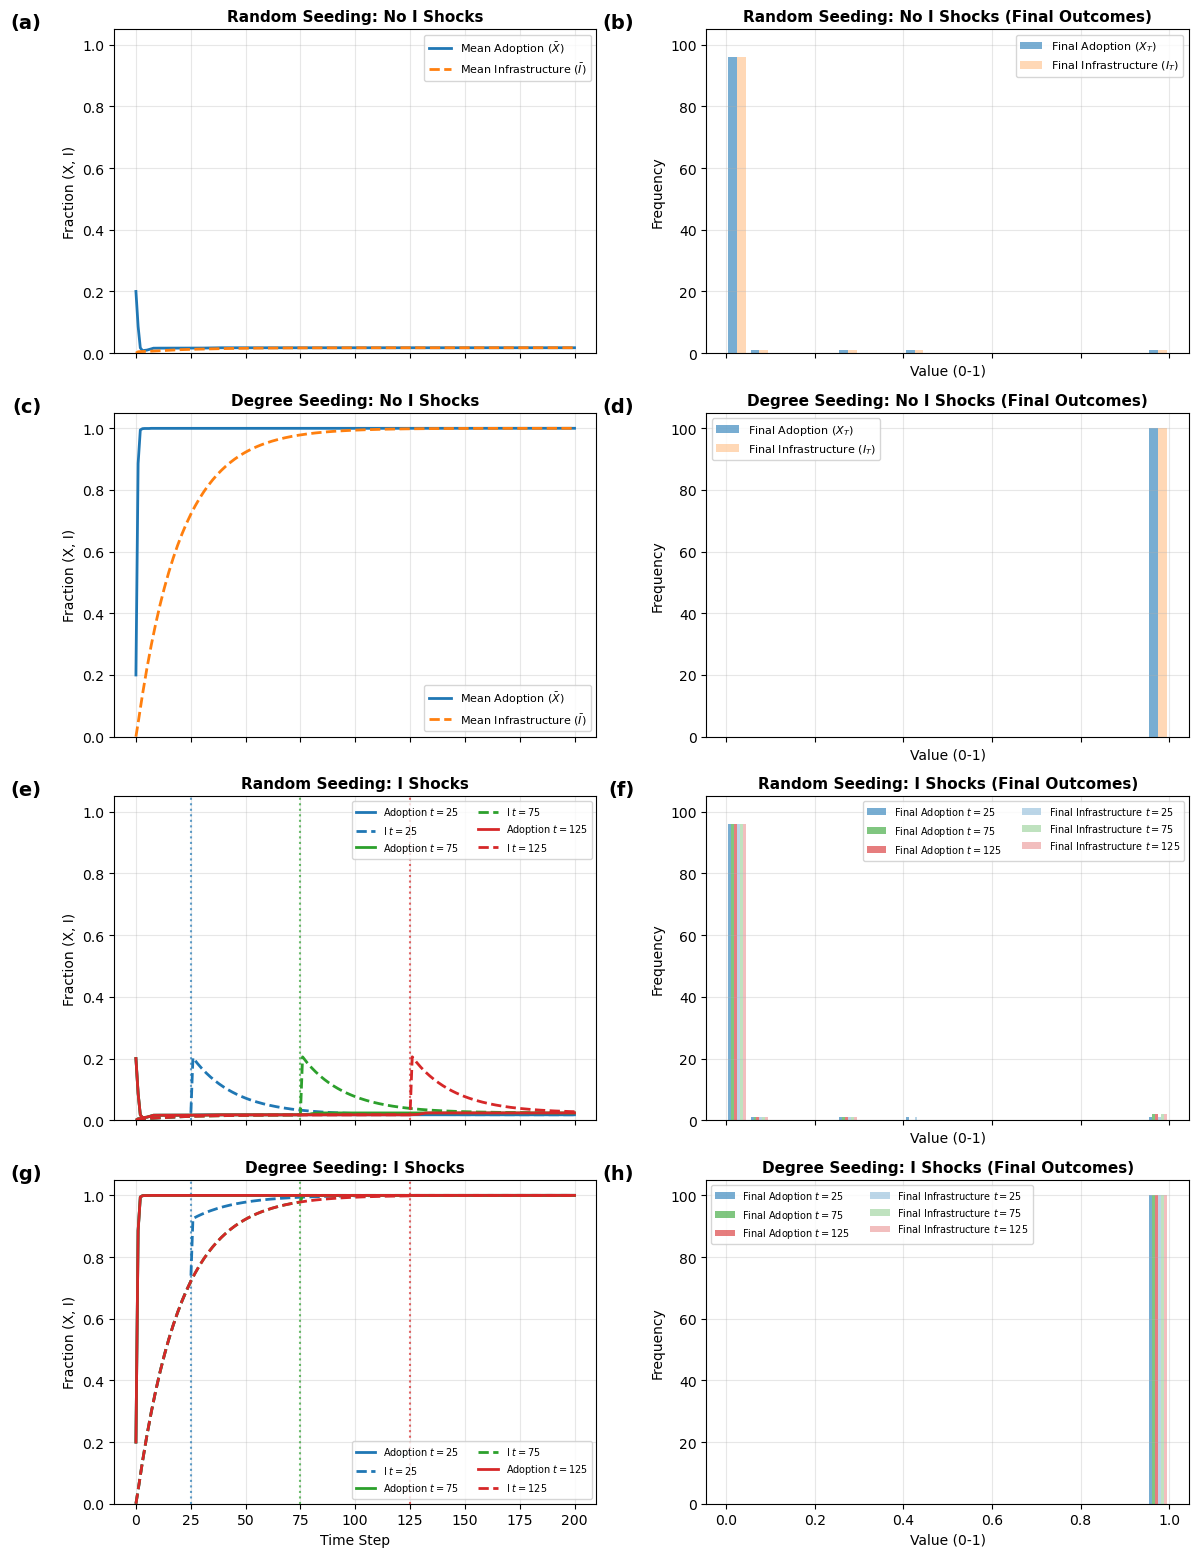

In [127]:
# =================================================================
# STEP 1: CRITICAL IMPORTS (MUST BE FIRST)
# =================================================================
import matplotlib.pyplot as plt
import numpy as np 
import networkx as nx # <--- CRITICAL: MUST BE HERE
import random
import math
from typing import Dict, Optional
from __future__ import annotations

# =================================================================
# STEP 2: MODEL DEFINITIONS (Must be defined before run_batch)
# =================================================================

# --- Helper function for color lightening (from original code) ---
def lighten_color(hex_color, factor=0.5):
    """ Lightens a given color by blending it with white. """
    # Convert hex to RGB
    rgb_tuple = tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
    
    # Calculate new RGB values blended with white (255)
    new_rgb = [int(r + (255 - r) * factor) for r in rgb_tuple]
    
    # Convert new RGB back to hex
    return f'#{new_rgb[0]:02x}{new_rgb[1]:02x}{new_rgb[2]:02x}'


# --- EVAgent and EVStagHuntModel Classes (Your working model) ---
class EVAgent:
# ... (insert the full EVAgent class definition here) ...
# ... (as provided in your previous message) ...

    def __init__(self, node_id: int, model: "EVStagHuntModel", init_strategy: str = "D"):
        self.node_id = node_id
        self.model = model
        self.strategy = init_strategy  # "C" or "D"
        self.payoff = 0.0
        self.next_strategy = init_strategy

    def step(self) -> None:
        """Compute payoff from interactions with neighbours."""
        I = self.model.infrastructure
        a0 = self.model.a0
        beta_I = self.model.beta_I
        b = self.model.b
        a_I = a0 + beta_I * I

        neighbors = list(self.model.G.neighbors(self.node_id))
        if not neighbors:
            self.payoff = 0.0
            return

        payoff = 0.0
        for nbr in neighbors:
            other = self.model.node_agent_map[nbr]
            s_i = self.strategy
            s_j = other.strategy
            if s_i == "C" and s_j == "C":
                payoff += a_I
            elif s_i == "C" and s_j == "D":
                payoff += 0.0
            elif s_i == "D" and s_j == "C":
                payoff += b
            else:  # D vs D
                payoff += b
        self.payoff = payoff

    def advance(self) -> None:
        """Compute next_strategy according to model's strategy_choice_func but DO NOT commit."""
        func = self.model.strategy_choice_func
        neighbors = [self.model.node_agent_map[n] for n in self.model.G.neighbors(self.node_id)]

        if func == "imitate":
            candidates = neighbors + [self]
            best = max(candidates, key=lambda a: a.payoff)
            self.next_strategy = best.strategy
        elif func == "logit":
            a_I = self.model.a0 + self.model.beta_I * self.model.infrastructure
            pi_C = 0.0
            pi_D = 0.0
            for other in neighbors:
                if other.strategy == "C":
                    pi_C += a_I
                    pi_D += self.model.b
                else:
                    pi_C += 0.0
                    pi_D += self.model.b
            tau = getattr(self.model, "tau", 1.0)
            denom = math.exp(pi_C / tau) + math.exp(pi_D / tau)
            P_C = math.exp(pi_C / tau) / denom if denom > 0 else 0.5
            self.next_strategy = "C" if random.random() < P_C else "D"
        else:
            raise ValueError(f"Unknown strategy choice function: {func}")

    def commit(self) -> None:
        """Apply next_strategy synchronously."""
        self.strategy = self.next_strategy

# --- EVStagHuntModel ---
class EVStagHuntModel:
    def __init__(
        self,
        initial_ev: int,
        a0: float,
        beta_I: float,
        b: float,
        g_I: float,
        I0: float,
        seed: int | None,
        network_type: str,
        n_nodes: int,
        p: float,
        m: int,
        strategy_choice_func: str = "imitate",
        tau: float = 1.0,
    ):
        self.random = random.Random(seed)
        self.seed = seed
        self.a0 = a0
        self.beta_I = beta_I
        self.b = b
        self.g_I = g_I
        self.infrastructure = float(I0)
        self.strategy_choice_func = strategy_choice_func
        self.tau = tau

        # Build network (This is the critical block)
        G = nx.Graph() # Initialize G as a networkx graph object
        if network_type == "ER":
            G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)
        elif network_type == "WS":
            G = nx.watts_strogatz_graph(n_nodes, max(2, 2*m), p, seed=seed)
        elif network_type == "BA":
            G = nx.barabasi_albert_graph(n_nodes, max(1, m), seed=seed)
        else:
            print(f"Warning: Unknown network type '{network_type}'. Initializing empty graph.")
            G = nx.Graph() # If type fails, still use a networkx object

        self.G = G

        # create agents: one per node
        nodes = list(self.G.nodes())
        total_nodes = len(nodes)
        k_ev = max(0, min(initial_ev, total_nodes))
        ev_nodes = set(self.random.sample(nodes, k_ev))
        self.node_agent_map: Dict[int, EVAgent] = {}
        for node in nodes:
            init_strategy = "C" if node in ev_nodes else "D"
            agent = EVAgent(node, self, init_strategy)
            self.node_agent_map[node] = agent

    def get_adoption_fraction(self) -> float:
        agents = list(self.node_agent_map.values())
        if not agents:
            return 0.0
        return sum(1 for a in agents if a.strategy == "C") / len(agents)
        
    def step(self) -> None:
        # compute payoffs
        for agent in list(self.node_agent_map.values()):
            agent.step()
        # choose next strategies (based on payoffs)
        for agent in list(self.node_agent_map.values()):
            agent.advance()
        # commit synchronously
        for agent in list(self.node_agent_map.values()):
            agent.commit()
        # update infrastructure: I <- clip(I + g_I*(X - I), 0, 1)
        X = self.get_adoption_fraction()
        I = self.infrastructure
        dI = self.g_I * (X - I)
        self.infrastructure = float(min(1.0, max(0.0, I + dI)))


# --- 1. Helper Function for Seeding (Final check) ---
def apply_seeding(model, X0_frac, method="random"):
    """
    Applies specific seeding strategies to the provided model instance.
    """
    nodes = list(model.G.nodes()) # <-- We are guaranteed model.G is a networkx object here.
    total_nodes = len(nodes)
    # Ensure initial EV count is proportional to the fraction
    k_ev = int(round(X0_frac * total_nodes))
    
    # Reset all agents to Defect first
    for agent in model.node_agent_map.values():
        agent.strategy = "D"
        agent.next_strategy = "D"

    target_nodes = []

    if k_ev <= 0:
        return

    if method == "random":
        # Use the model's random instance for reproducibility
        target_nodes = model.random.sample(nodes, k_ev)
        
    elif method == "degree":
        # Sort nodes by degree (high to low)
        # Note: model.G.degree() returns a DegreeView object, convertible to dict
        degrees = dict(model.G.degree())
        # Sort keys by value descending
        sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)
        target_nodes = sorted_nodes[:k_ev]

    # Apply "C" strategy to chosen targets
    for node_id in target_nodes:
        model.node_agent_map[node_id].strategy = "C"
        model.node_agent_map[node_id].next_strategy = "C"


# --- 2. Simulation Runner (The run_batch function from your script) ---
def run_batch(n_trials, steps, seeding_method, params, shock_steps=None, shock_magnitude=0.20):
    """ Runs a batch of simulations, applying infrastructure shocks if provided. """
    X_trajectories = []
    I_trajectories = []
    final_X = []
    final_I = []

    for i in range(n_trials):
        # Use a new seed for each trial to ensure independent runs
        trial_seed = params.get('seed', 0) * n_trials * 10 + i 

        # Initialize model with 0 initial EVs so we can manually seed them
        model = EVStagHuntModel(
            initial_ev=0, 
            a0=params['a0'], beta_I=params['beta_I'], b=params['b'], 
            g_I=params['g_I'], I0=params['I0'], 
            seed=trial_seed,
            network_type=params['network_type'], 
            n_nodes=params['n_nodes'], p=params['p'], m=params['m'],
            strategy_choice_func=params['func']
        )
        
        # Apply the specific seeding method
        apply_seeding(model, params['X0_frac'], method=seeding_method)
        
        # storage for this trial
        trial_X = []
        trial_I = []
        
        # Run time steps
        for t in range(steps):
            trial_X.append(model.get_adoption_fraction())
            trial_I.append(model.infrastructure)
            
            # --- Apply Infrastructure Shock ---
            if shock_steps and t in shock_steps: 
                model.infrastructure = min(1.0, model.infrastructure + shock_magnitude)
            
            model.step()
            
        # Capture final state (after T steps)
        trial_X.append(model.get_adoption_fraction())
        trial_I.append(model.infrastructure)
        
        X_trajectories.append(trial_X)
        I_trajectories.append(trial_I)
        final_X.append(trial_X[-1])
        final_I.append(trial_I[-1])

    return np.array(X_trajectories), np.array(I_trajectories), np.array(final_X), np.array(final_I)


# =================================================================
# STEP 3: EXECUTION BLOCK (The original code that sets params and runs simulations)
# =================================================================

# --- 3. Configuration ---
GLOBAL_SEED = 42 
PARAMS = {
    'a0': 2.0,            
    'beta_I': 2.0,
    'b': 1.0,
    'g_I': 0.05,
    'I0': 0.00,
    'X0_frac': 0.20,
    'network_type': 'BA', # Assumes you have the networkx library!
    'n_nodes': 200,
    'p': 0.05,
    'm': 2,
    'func': 'imitate',
    'seed': GLOBAL_SEED
}

TRIALS = 100
STEPS = 200
SHOCK_TIMES = [25, 75, 125]
SHOCK_MAG = 0.20

# --- 4. Execute Simulations ---
RESULTS = {}

def get_key_prefix(seeding_method):
    return 'Rand' if seeding_method == 'random' else 'Deg'

print("Running Baseline 1: Random Seeding, No Shocks...")
X_traj, I_traj, final_X, final_I = run_batch(TRIALS, STEPS, "random", PARAMS)
RESULTS['Rand_NoShock'] = (X_traj, I_traj, final_X, final_I)

print("Running Baseline 2: Targeted Seeding, No Shocks...")
X_traj, I_traj, final_X, final_I = run_batch(TRIALS, STEPS, "degree", PARAMS)
RESULTS['Deg_NoShock'] = (X_traj, I_traj, final_X, final_I)

for t_shock in SHOCK_TIMES:
    key = f'{get_key_prefix("random")}_Shock_{t_shock}'
    print(f"Running Scenario: Random Seeding, Shock at t={t_shock}...")
    X_traj, I_traj, final_X, final_I = run_batch(TRIALS, STEPS, "random", PARAMS, shock_steps={t_shock}, shock_magnitude=SHOCK_MAG)
    RESULTS[key] = (X_traj, I_traj, final_X, final_I)

for t_shock in SHOCK_TIMES:
    key = f'{get_key_prefix("degree")}_Shock_{t_shock}'
    print(f"Running Scenario: Targeted Seeding, Shock at t={t_shock}...")
    X_traj, I_traj, final_X, final_I = run_batch(TRIALS, STEPS, "degree", PARAMS, shock_steps={t_shock}, shock_magnitude=SHOCK_MAG)
    RESULTS[key] = (X_traj, I_traj, final_X, final_I)


# =================================================================
# STEP 4: VISUALIZATION (With requested legend/labeling changes)
# =================================================================

# Plotting setup
fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharex='col')
time_axis = range(STEPS + 1)
BASE_I_COLOR = '#ff7f0e' 
alpha_hist = 0.6
bins_count = 20
y_lim_hist_freq = 105 
LIGHTENING_FACTOR = 0.5 

# Color palette for the three adoption trajectories (keys updated)
COLOR_X_SHOCKS = {
    25: '#1f77b4',  # Blue (Early shock)
    75: '#2ca02c', # Green (Mid shock)
    125: '#d62728', # Red (Late shock)
}

# New plotting approach: Iterate over (seeding_method, has_shock) pairs
PLOT_ORDER = [
    {'row': 0, 'seeding_method': 'random', 'has_shock': False, 'key_prefix': 'Rand', 'base_color_key': 25},
    {'row': 1, 'seeding_method': 'degree', 'has_shock': False, 'key_prefix': 'Deg', 'base_color_key': 25},
    {'row': 2, 'seeding_method': 'random', 'has_shock': True, 'key_prefix': 'Rand'},
    {'row': 3, 'seeding_method': 'degree', 'has_shock': True, 'key_prefix': 'Deg'},
]

# --- Legend Size Consistency ---
LEGEND_FONT_NO_SHOCK = 8
LEGEND_FONT_SHOCK = 7

# --- Subplot Labeling ---
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
label_idx = 0


for item in PLOT_ORDER:
    row = item['row']
    seeding_method = item['seeding_method']
    has_shock = item['has_shock']
    prefix = item['key_prefix']
    
    # --- Data Retrieval ---
    if not has_shock:
        key = f"{prefix}_NoShock"
        X_data, I_data, final_X, final_I = RESULTS[key]
        base_color = COLOR_X_SHOCKS[item['base_color_key']]
    else:
        # For shock scenarios, we don't need a single 'base' data key here
        pass

    
    # --- Column 0: Dynamics Trajectories (X/I over time) ---
    ax_dyn = axs[row, 0]
    
    # Add Subplot Label (e.g., (a))
    ax_dyn.text(-0.15, 1.05, subplot_labels[label_idx], transform=ax_dyn.transAxes, 
                fontsize=14, va='top', ha='right', fontweight='bold')
    label_idx += 1
    
    # Title Setup
    if not has_shock:
        ax_dyn.set_title(f'{seeding_method.capitalize()} Seeding: No I Shocks', fontsize=11, fontweight='bold')
    else:
        ax_dyn.set_title(f'{seeding_method.capitalize()} Seeding: I Shocks', fontsize=11, fontweight='bold')

    ax_dyn.set_ylabel('Fraction (X, I)')
    ax_dyn.set_ylim(0, 1.05)
    ax_dyn.grid(True, alpha=0.3)
    
    # Dynamics Plotting Logic
    if not has_shock:
        # Plot Base (No Shock)
        mean_X = np.mean(X_data, axis=0)
        mean_I = np.mean(I_data, axis=0)
        
        ax_dyn.plot(time_axis, mean_X, label=r'Mean Adoption ($\bar{X}$)', color=base_color, linewidth=2)
        ax_dyn.plot(time_axis, mean_I, label=r'Mean Infrastructure ($\bar{I}$)', color=BASE_I_COLOR, linewidth=2, linestyle='--')
        
        ax_dyn.legend(loc='best', fontsize=LEGEND_FONT_NO_SHOCK) 
        
    else: # Shock scenarios
        # Plot three individual shock adoption and infrastructure trajectories
        for t_shock in SHOCK_TIMES:
            shock_key = f'{prefix}_Shock_{t_shock}'
            X_shock, I_shock, _, _ = RESULTS[shock_key]
            
            shock_color = COLOR_X_SHOCKS[t_shock]

            # 1. Plot Mean Adoption (Solid Line)
            mean_X_shock = np.mean(X_shock, axis=0)
            ax_dyn.plot(time_axis, mean_X_shock, 
                             label=f'Adoption $t={t_shock}$', 
                             color=shock_color, 
                             linewidth=2)

            # 2. Plot Mean Infrastructure (Dashed Line, Same Color)
            mean_I_shock = np.mean(I_shock, axis=0)
            ax_dyn.plot(time_axis, mean_I_shock, 
                             label=f'I $t={t_shock}$', 
                             color=shock_color, 
                             linewidth=2, 
                             linestyle='--')
            
            # Add vertical line for this shock time
            ax_dyn.axvline(x=t_shock, color=shock_color, linestyle=':', alpha=0.7)

        ax_dyn.legend(loc='best', fontsize=LEGEND_FONT_SHOCK, ncol=2)


    # --- Column 1: Final Outcomes Distribution (Histograms) ---
    ax_hist = axs[row, 1]
    
    # Add Subplot Label (e.g., (b))
    ax_hist.text(-0.15, 1.05, subplot_labels[label_idx], transform=ax_hist.transAxes, 
                fontsize=14, va='top', ha='right', fontweight='bold')
    label_idx += 1
    
    # Title Setup
    if not has_shock:
        ax_hist.set_title(f'{seeding_method.capitalize()} Seeding: No I Shocks (Final Outcomes)', fontsize=11, fontweight='bold')
    else:
        ax_hist.set_title(f'{seeding_method.capitalize()} Seeding: I Shocks (Final Outcomes)', fontsize=11, fontweight='bold')

    ax_hist.set_xlabel('Value (0-1)')
    ax_hist.set_ylabel('Frequency')
    ax_hist.set_ylim(0, y_lim_hist_freq) 
    ax_hist.grid(True, alpha=0.3)
    
    # Histogram Plotting Logic
    if not has_shock:
        # Plot Base (No Shock) Histogram
        light_base_I_color = lighten_color(BASE_I_COLOR, factor=LIGHTENING_FACTOR)
        
        ax_hist.hist(
            [final_X, final_I],
            bins=bins_count, range=(0,1), alpha=alpha_hist,
            color=[base_color, light_base_I_color],
            label=[r'Final Adoption ($X_T$)', r'Final Infrastructure ($I_T$)']
        )
        ax_hist.legend(loc='best', fontsize=LEGEND_FONT_NO_SHOCK)
    else: # Shock scenarios
        
        # Prepare data for adoption distributions
        hist_data = [RESULTS[f'{prefix}_Shock_{t}'][2] for t in SHOCK_TIMES]
        hist_colors_X = [COLOR_X_SHOCKS[t] for t in SHOCK_TIMES] # Solid colors for X
        
        hist_labels = [f'Final Adoption $t={t}$' for t in SHOCK_TIMES] 
        
        # Prepare data for infrastructure distributions (using LIGHTENED shock colors)
        I_shock_data = [RESULTS[f'{prefix}_Shock_{t}'][3] for t in SHOCK_TIMES]
        hist_colors_I = [lighten_color(COLOR_X_SHOCKS[t], factor=LIGHTENING_FACTOR) for t in SHOCK_TIMES]
        
        I_shock_labels = [f'Final Infrastructure $t={t}$' for t in SHOCK_TIMES] 
        
        # Combine lists for plotting
        combined_hist_data = hist_data + I_shock_data
        combined_hist_colors = hist_colors_X + hist_colors_I
        combined_hist_labels = hist_labels + I_shock_labels

        # Plot all six distributions (three X, three I)
        ax_hist.hist(
            combined_hist_data,
            bins=bins_count, range=(0,1), alpha=alpha_hist,
            color=combined_hist_colors,
            label=combined_hist_labels
        )
        ax_hist.legend(loc='best', fontsize=LEGEND_FONT_SHOCK, ncol=2)

# Set common X labels for the bottom row of each plot type
axs[3, 0].set_xlabel('Time Step')
axs[3, 1].set_xlabel('Value (0-1)')

# Adjust layout to prevent overlap and display the figure
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()